In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import optuna 
import logging
from datetime import timedelta, datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from concurrent.futures import ThreadPoolExecutor

# Configuración de logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled = True
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [12]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [13]:
proporcion_entrenamiento = 0.80
horizon = 1
fourier_order = 4

Y_df_grouped = Y_df.groupby('unique_id')

In [14]:
# Inicialización de DataFrames para resultados
forecast_result_list = []
modelo_precision_forecast_list = []
timestamp = datetime.now().strftime('%Y-%m-%d')

# Función para realizar la optimización con Optuna
def optimize_prophet(trial, ts_prophet, training_duration, horizon):
    param_grid = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95)
    }

    model = Prophet(**param_grid, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, interval_width=0.8)
    model.add_country_holidays(country_name='US')

    model.fit(ts_prophet)
    df_cv_model = cross_validation(model, initial=timedelta(days=training_duration), horizon=timedelta(days=horizon), disable_tqdm=True, parallel='threads')
    df_metrics = performance_metrics(df_cv_model)

    smape_score = (df_metrics.groupby('horizon').mean())['smape'].mean()
    mape_score = (df_metrics.groupby('horizon').mean())['mape'].mean()
    mse_score = (df_metrics.groupby('horizon').mean())['mse'].mean()
    rmse_score = (df_metrics.groupby('horizon').mean())['rmse'].mean()
    mae_score = (df_metrics.groupby('horizon').mean())['mae'].mean()

    trial.set_user_attr("mape_score", mape_score)
    trial.set_user_attr("mse_score", mse_score)
    trial.set_user_attr("rmse_score", rmse_score)
    trial.set_user_attr("mae_score", mae_score)

    return smape_score

In [15]:
def forecast_for_Ticker(id, ts, horizon, proporcion_entrenamiento):
    try:
        start_time = time.time()  # Inicia el cronómetro

        # Ajuste de la serie temporal
        ts = ts.drop('unique_id', axis=1).sort_values(by='ds').reset_index(drop=True)
        ts['ds'] = pd.to_datetime(ts['ds'])

        # Splitting Training y Validación
        indice_entrenamiento = int(len(ts) * proporcion_entrenamiento) 
        ts_entrenamiento = ts.iloc[:indice_entrenamiento].copy()
        ts_validacion = ts.iloc[indice_entrenamiento:].copy()
        ts_prophet = pd.concat([ts_entrenamiento, ts_validacion]).reset_index(drop=True)

        # Implementación del modelo Prophet
        training_duration_days = (len(ts_entrenamiento) * 30.5) - (horizon * 30.5)  # Ajustar para horizonte en días
        horizon_days = horizon * 30.5  # Horizonte en días

        # Optimización de parámetros
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: optimize_prophet(trial, ts_prophet, training_duration_days, horizon_days), n_trials=25, n_jobs=-1, timeout=180)

        smape_score = study.best_value
        accuracy = round((1 - smape_score) * 100, 2) if smape_score < 1 else 0.00

        mape_score = study.best_trial.user_attrs["mape_score"]
        mse_score = study.best_trial.user_attrs["mse_score"]
        rmse_score = study.best_trial.user_attrs["rmse_score"]
        mae_score = study.best_trial.user_attrs["mae_score"]
        best_params = study.best_trial.params

        model = Prophet(**best_params, interval_width=0.8)
        model.add_country_holidays(country_name='US')

        model.fit(ts_prophet)

        # Calcular la última fecha y el inicio del horizonte deseado
        last_date = ts['ds'].max()  
        start_date = last_date - pd.DateOffset(months=horizon) 

        # Generar fechas para exactamente 6 meses
        future_dates = pd.date_range(start=start_date, periods=horizon, freq='MS') 
        future = pd.DataFrame({'ds': future_dates})  

        # Hacer la predicción para estas fechas
        forecast = model.predict(future)

        end_time = time.time()
        forecast_duration = end_time - start_time

        resultado_accuracy = {
            'ticker': id,
            'accuracy': accuracy,
            'smape': smape_score,
            'mape': mape_score,
            'mae': mae_score,
            'mse': mse_score,
            'rmse': rmse_score,
            'forecast_duration_seconds': forecast_duration
        }

        forecast['ticker'] = id
        forecast['yhat'] = forecast['yhat'].round(2)
        forecast['ds'] = forecast['ds'].dt.strftime('%d-%m-%Y')

        return resultado_accuracy, forecast[['ticker', 'ds', 'yhat']].to_dict('records')
    except Exception as e:
        logging.error(f'Error procesando {id}. No existe suficiente información para realizar el forecasting: {e}')
        return None, None


# Ejecución en paralelo
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(forecast_for_Ticker, id, ts, horizon, proporcion_entrenamiento) for id, ts in Y_df_grouped]
    for future in futures:
        try:
            result = future.result()
            if result is not None:
                resultado_accuracy, forecast_records = result
                if resultado_accuracy is not None:
                    modelo_precision_forecast_list.append(resultado_accuracy)
                    print(f"SMAPE: {resultado_accuracy.get('smape'):.2f}, MAPE: {resultado_accuracy.get('mape'):.2f}, MAE: {resultado_accuracy.get('mae'):.2f}, MSE: {resultado_accuracy.get('mse'):.2f}, RMSE: {resultado_accuracy.get('rmse'):.2f}, Forecast Duration: {resultado_accuracy.get('forecast_duration_seconds'):.2f} seconds")
                if forecast_records is not None:
                    forecast_result_list.extend(forecast_records)
        except Exception as e:
            print(f'Error processing future: {e}'); 

SMAPE: 0.16, MAPE: 0.15, MAE: 19.35, MSE: 549.53, RMSE: 22.97, Forecast Duration: 3792.40 seconds
SMAPE: 0.22, MAPE: 0.26, MAE: 31.96, MSE: 1637.23, RMSE: 38.71, Forecast Duration: 3778.79 seconds
SMAPE: 0.42, MAPE: 0.50, MAE: 15392.58, MSE: 311055889.15, RMSE: 17426.45, Forecast Duration: 2566.74 seconds
SMAPE: 0.20, MAPE: 0.19, MAE: 22.88, MSE: 664.89, RMSE: 25.15, Forecast Duration: 3598.38 seconds
SMAPE: 0.08, MAPE: 0.08, MAE: 10.63, MSE: 229.73, RMSE: 13.63, Forecast Duration: 3701.57 seconds
SMAPE: 0.39, MAPE: 0.33, MAE: 81.94, MSE: 10853.70, RMSE: 102.21, Forecast Duration: 2952.98 seconds
SMAPE: 0.15, MAPE: 0.15, MAE: 37.91, MSE: 2101.95, RMSE: 43.22, Forecast Duration: 3770.68 seconds
SMAPE: 0.36, MAPE: 0.33, MAE: 10.93, MSE: 331.16, RMSE: 14.29, Forecast Duration: 3793.40 seconds


In [16]:
modelo_precision_forecast_list = [item for item in modelo_precision_forecast_list if item is not None]
forecast_result_list = [item for item in forecast_result_list if item is not None]

# Crear los dataframes pandas de los resultados
modelo_precision_forecast = pd.DataFrame(modelo_precision_forecast_list)
forecast_result = pd.DataFrame(forecast_result_list)

In [17]:
modelo_precision_forecast

,ticker,accuracy,smape,mape,mae,mse,rmse,forecast_duration_seconds
0,AAPL,84.26,0.157364,0.150412,19.354389,5.495274e+02,22.974856,3792.404294
1,AMZN,77.71,0.222896,0.255300,31.955848,1.637228e+03,38.710229,3778.790818
2,BTC-USD,57.85,0.421457,0.495856,15392.580720,3.110559e+08,17426.454955,2566.738632
3,GOOGL,80.08,0.199189,0.192863,22.882105,6.648914e+02,25.151186,3598.376146
4,IBM,91.64,0.083607,0.079842,10.627916,2.297318e+02,13.626886,3701.573925
5,META,60.90,0.390981,0.325016,81.942695,1.085370e+04,102.213929,2952.984926
6,MSFT,85.24,0.147600,0.147743,37.907772,2.101946e+03,43.222834,3770.683860
7,NVDA,64.19,0.358083,0.329715,10.931278,3.311638e+02,14.287413,3793.404508


In [23]:
forecast_result.tail(8)

,ticker,ds,yhat
0,AAPL,2024-09-01,204.87
1,AMZN,2024-09-01,175.34
2,BTC-USD,2024-09-01,44985.35
3,GOOGL,2024-09-01,151.71
4,IBM,2024-09-01,182.81
5,META,2024-09-01,551.89
6,MSFT,2024-09-01,386.06
7,NVDA,2024-09-01,87.19


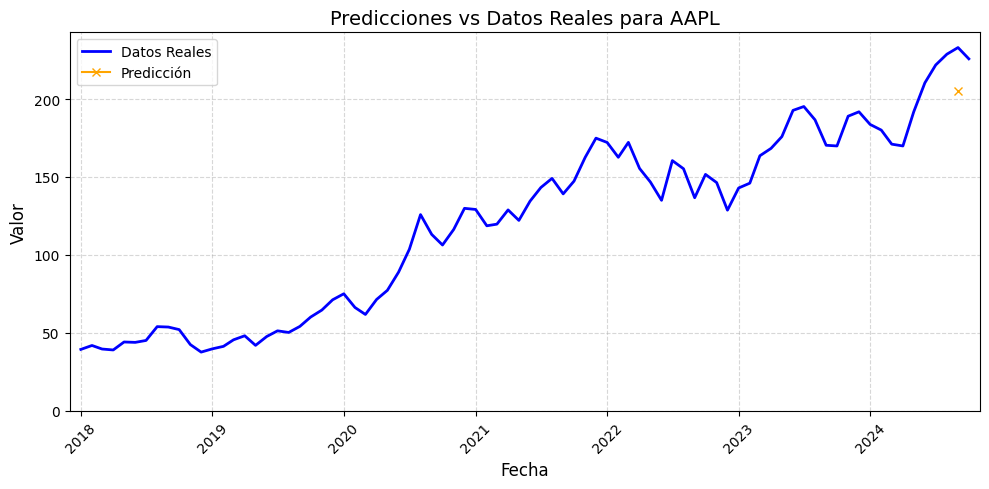

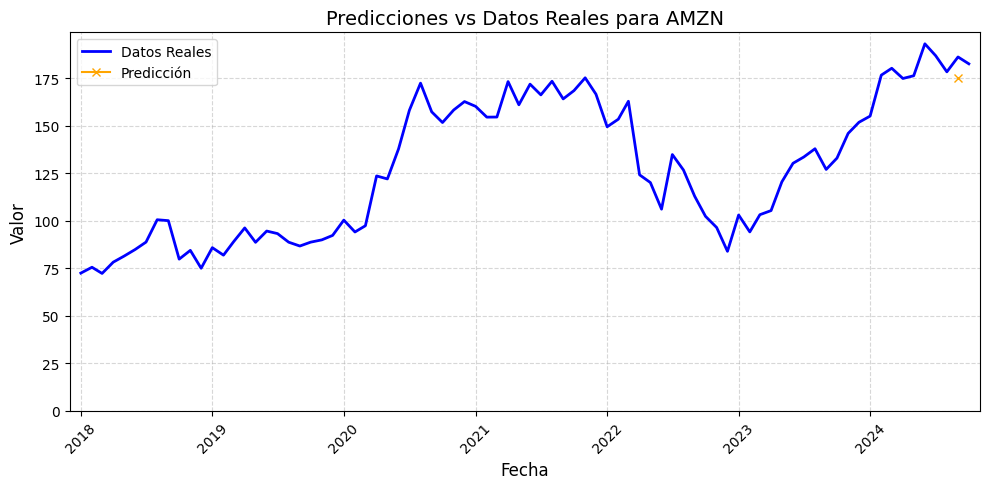

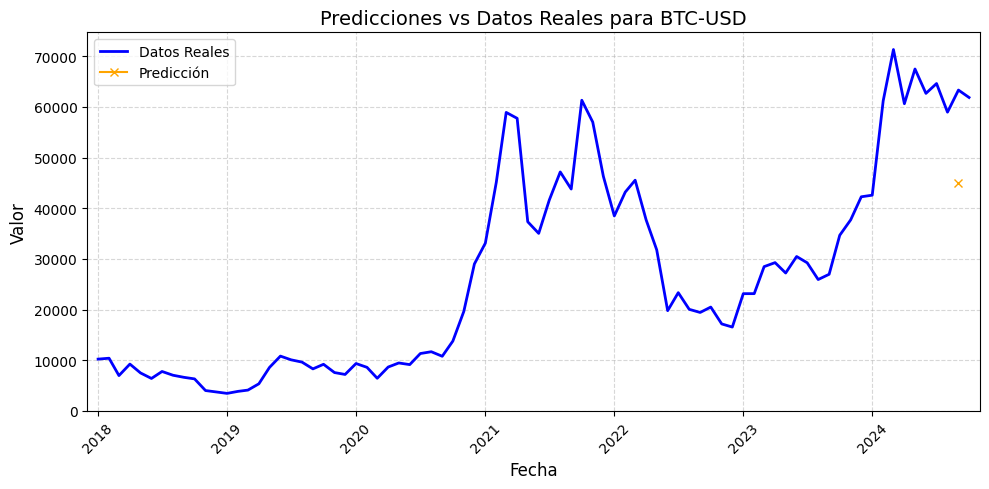

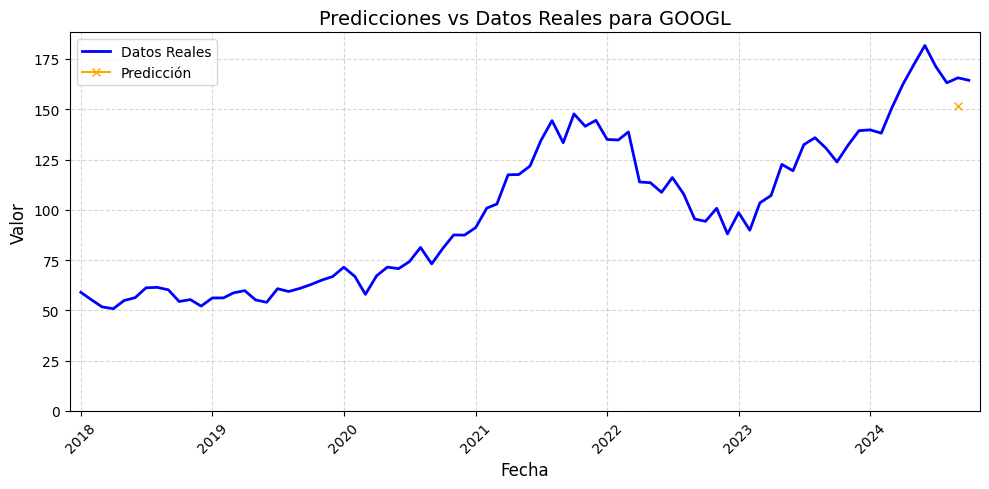

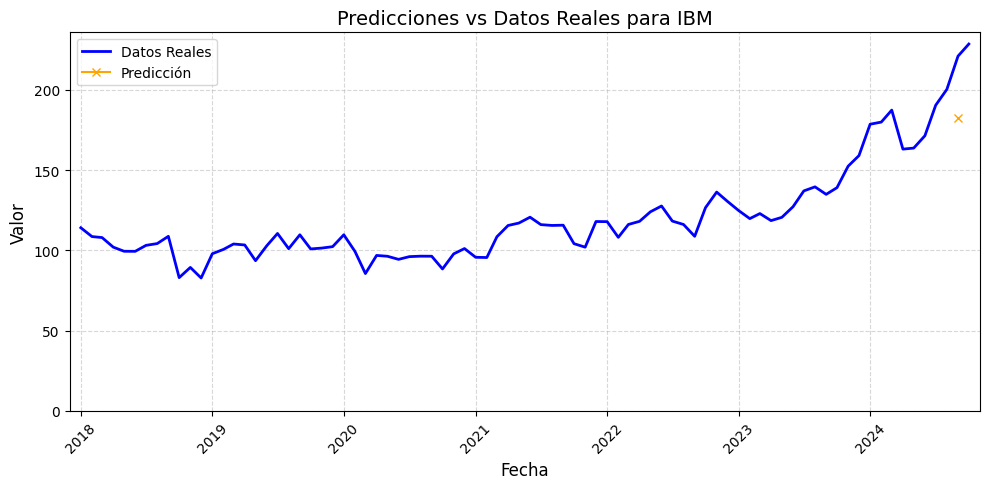

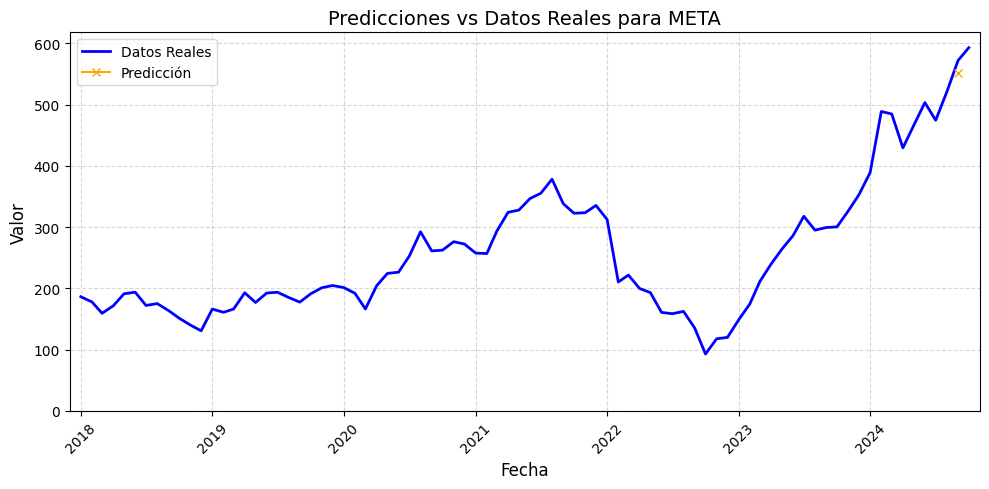

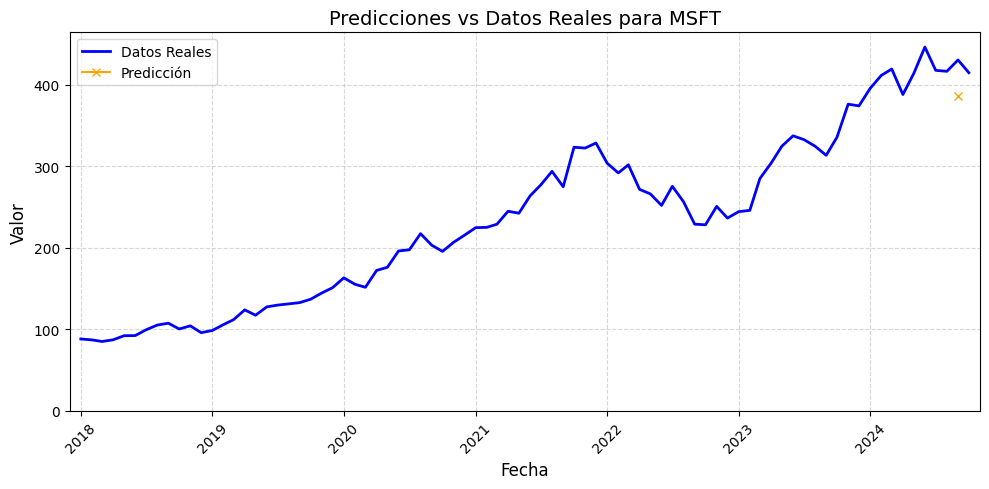

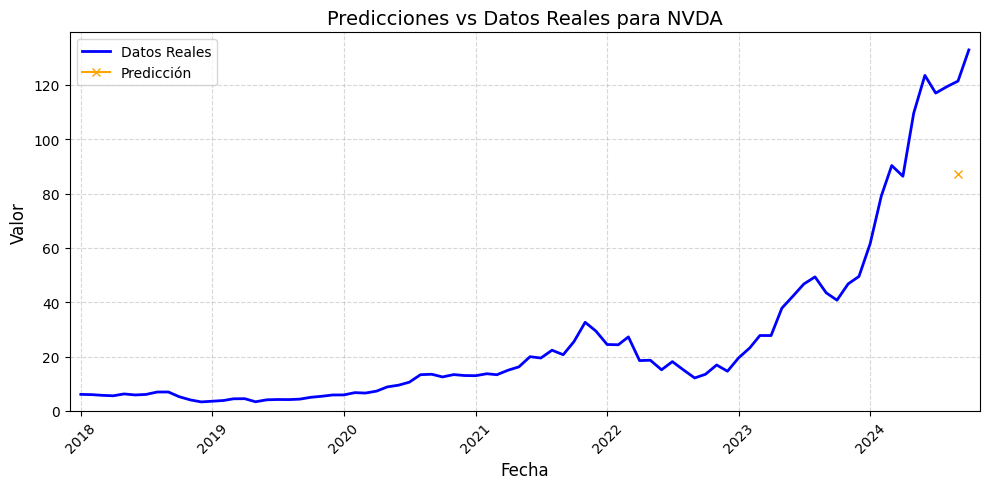

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_predictions(forecast_result, Y_df):
    # Asegúrate de que 'ds' en forecast_result esté en el formato correcto
    forecast_result['ds'] = pd.to_datetime(forecast_result['ds'], format='%d-%m-%Y')
    Y_df['ds'] = pd.to_datetime(Y_df['ds'], format='%d-%m-%Y')  # Asegúrate de que Y_df también tenga el formato correcto

    # Filtrar datos a partir de 2018
    start_date = pd.Timestamp('2018-01-01')
    forecast_result = forecast_result[forecast_result['ds'] >= start_date]
    Y_df = Y_df[Y_df['ds'] >= start_date]

    # Grafica predicciones y datos reales para cada ticker
    for ticker in forecast_result['ticker'].unique():
        plt.figure(figsize=(10, 5))

        # Filtra predicciones y datos reales por ticker
        forecast_data = forecast_result[forecast_result['ticker'] == ticker]
        actual_data = Y_df[Y_df['unique_id'] == ticker]

        # Grafica datos reales como línea sólida
        plt.plot(actual_data['ds'], actual_data['y'], label='Datos Reales', linestyle='-', color='blue', linewidth=2)

        # Grafica predicciones como línea discontinua
        plt.plot(forecast_data['ds'], forecast_data['yhat'], label='Predicción', marker='x', color='orange')

        # Configura el gráfico
        plt.title(f'Predicciones vs Datos Reales para {ticker}', fontsize=14)
        plt.xlabel('Fecha', fontsize=12)
        plt.ylabel('Valor', fontsize=12)
        plt.legend(fontsize=10)
        plt.xticks(rotation=45)

        # Ajustar límites del eje para mostrar todos los datos
        plt.xlim([Y_df['ds'].min() - pd.DateOffset(months=1), Y_df['ds'].max() + pd.DateOffset(months=1)]) 
        plt.ylim(bottom=0)  

        # Ajustar el espacio de la figura
        plt.subplots_adjust(bottom=0.15)  # Mantén este ajuste si es necesario

        plt.tight_layout()
        plt.grid(visible=True, linestyle='--', alpha=0.5)

        # Muestra el gráfico
        plt.show()

# Llama a la función para graficar
plot_predictions(forecast_result, Y_df)
